In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

data = pd.read_parquet('Data/pump_station_data.parquet')
data = data[:]["2023-02-14":"2023-02-16"]
data_10s = data.resample("10s").mean()
# fig, ax = plt.subplots(2)
# ax[0].plot(data['outflow'])
# ax[1].plot(data['height'])
# fig.show
# fig, ax = plt.subplots(2)
# ax[0].plot(data['pump1_rpm'])
# ax[1].plot(data['pump1_power'])
# fig.show

In [39]:
import sklearn.model_selection as modsel
# use only a day for training
data_reduced = data_10s["2023-02-14 13:30:00":"2023-02-15 10:00:00"]

data_train, data_test = modsel.train_test_split(data_reduced, test_size=0.2, shuffle=False)

In [40]:
# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_train = data_train.drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)
x_train = x_train.to_numpy()
y_train = data_train['outflow'].values.reshape(-1,1)
print(type(y_train))

x_test = data_test[15:].drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)

x_test = x_test.to_numpy()
y_test = data_test[15:]['outflow'].values.reshape(-1,1)
print(x_train.size)

<class 'numpy.ndarray'>
11808


In [41]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

torch.manual_seed(0)

Using cuda device


In [42]:
# build a neural network for the multiple input data
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
       
for a in ['RReLU']:
    narx_net = NARXNN(
            ylag=1,
            xlag= [[1,2],[1,2]],
            basis_function=basis_function,
            model_type="NARMAX",
            loss_func="mse_loss",
            optimizer="Adam",
            epochs=5000,
            device='cuda',
            learning_rate = 4e-3,
            verbose=False,
            optim_params={
                "betas": (0.9, 0.999),
                "eps": 1e-05,
            }, 
        )
    class NARX(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.lin = nn.Linear(5, 30)
                    self.lin2 = nn.Linear(30, 64)
                    self.lin3 = nn.Linear(64, 64)
                    self.lin4 = nn.Linear(64, 64)
                    self.lin5 = nn.Linear(64, 30)              
                    self.lin6 = nn.Linear(30, 1)
                    self.tanh = eval("nn."+a+"()")
                    

                def forward(self, xb):
                    print(xb.size)
                    print(type(xb))
                    #xb = xb.reshape(-1,13)
                    z = self.lin(xb)
                    z = self.tanh(z)
                    z = self.lin2(z)
                    z = self.tanh(z)
                    z = self.lin3(z)
                    z = self.tanh(z)
                    z = self.lin4(z)
                    z = self.tanh(z)
                    z = self.lin5(z)
                    z = self.tanh(z)
                    z = self.lin6(z)
                    z = self.tanh(z)
                    
                    return z
    narx_net.net = NARX()
    if device == "cuda": 
        narx_net.net.to(torch.device("cuda"))
    # Train the model on the chosen test slot and the test data which is the last 20% of the train time slot
    narx_net.fit(X=x_train, y=y_train, X_test=x_test, y_test=y_test)

<built-in method size of Tensor object at 0x7fb2b1f5fdd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4cb58b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2b1f5fdd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4cb58b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2b1f5fdd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4cb58b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2b1f5fdd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4cb58b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2b1f5fdd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4cb58b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2b1f5fdd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4cb58b0>
<class 'torch.Tensor'>
<built-in method size of Ten

In [43]:
# Predict the values with the created model and compare them to the actual values from the time slot one hour after the training time slot
yhat = narx_net.predict(X=x_test, y=y_test, forecast_horizon=100)
    
# Calculate the error of the model compared to the testing time slot
mse = mean_squared_error(y_test, yhat)
print("MSE: ", mse)
rrse = root_relative_squared_error(y_test, yhat)
print("RRSE: ",rrse) 

<built-in method size of Tensor object at 0x7fb2d4c84050>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb312d40e30>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c3aab0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c84050>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb312d40e30>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c3aab0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c84050>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb312d40e30>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c3aab0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c84050>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb312d40e30>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fb2d4c3aab0>
<class 'torch.Tensor'>
<built-in method size of Ten

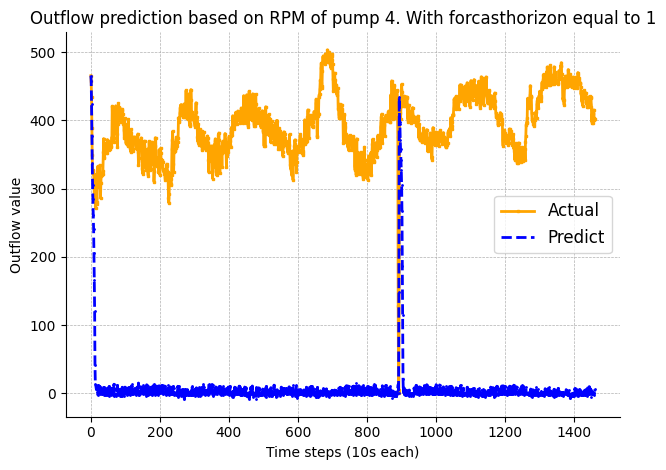

In [44]:
fig, ax = plt.subplots()
ax.plot(y_test, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 4. With forcasthorizon equal to 1")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()

plt.show()
#plt.savefig()

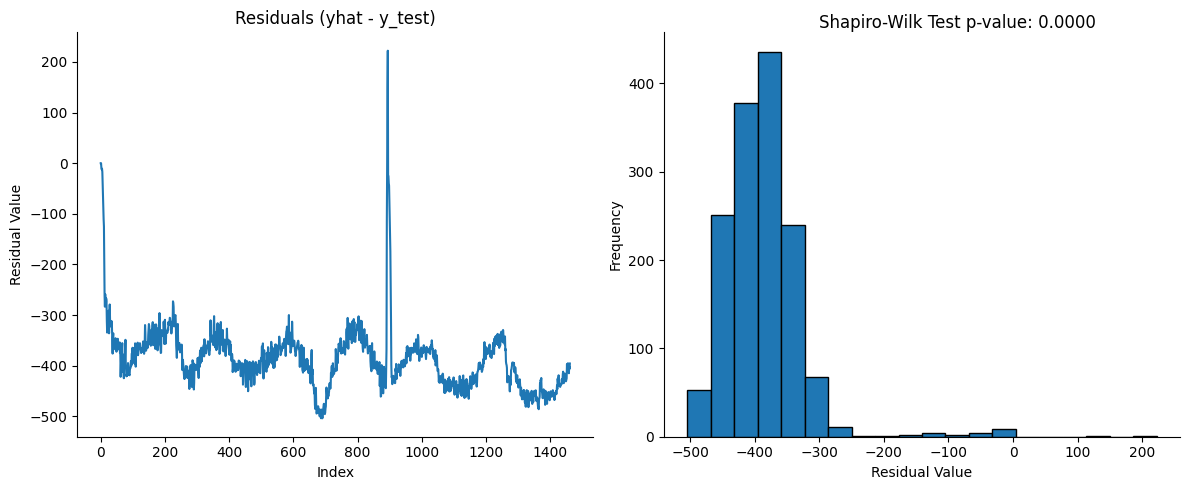

Shapiro-Wilk Test result:
Statistic: 0.7796, p-value: 0.0000


In [45]:
from scipy.stats import shapiro
residuals = yhat - y_test


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")